<img src="img/svds_logo.png" alt="SVDS" width="500" align="left">

# PyData San Francisco 2016
## Applied Time Series Econometrics in Python (and R) Tutorial
### Section 4: Seasonal ARIMA Models

### Topics in this section include 

  - 4.1 Mathematical formulation of Seasonal ARIMA (SARIMA) models
  - 4.2 Building a seasonal ARIMA model for forecasting
  - Exercise 4

In [2]:
# Set up

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np

# Remote Data Access
import pandas_datareader.data as web
import datetime
# reference: https://pandas-datareader.readthedocs.io/en/latest/remote_data.html

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from statsmodels.graphics.api import qqplot

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/miyainnyc/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Motivation of Using Seasonal ARIMA Model

In [3]:
# Import a time series
# This is a series that we introduced in Section 1 of this tutorial

air = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])

In [4]:
# Examine the basic structure of the data
print("Data shape:", air.shape, "\n")
print("First 5 observations of the data series:", "\n", air.head())
print("Last 5 observations of the data series:", "\n", air.tail())

Data shape: (144, 1) 

First 5 observations of the data series: 
             n_pass_thousands
Month                       
1949-01-01               112
1949-02-01               118
1949-03-01               132
1949-04-01               129
1949-05-01               121
Last 5 observations of the data series: 
             n_pass_thousands
Month                       
1960-08-01               606
1960-09-01               508
1960-10-01               461
1960-11-01               390
1960-12-01               432


In [5]:
# Examine the patterns of ACF and PACF (along with the time series plot and histogram)

def tsplot(y, lags=None, title='', figsize=(14, 8)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    
    Original source: https://tomaugspurger.github.io/modern-7-timeseries.html
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    fig.tight_layout()
    return ts_ax, acf_ax, pacf_ax

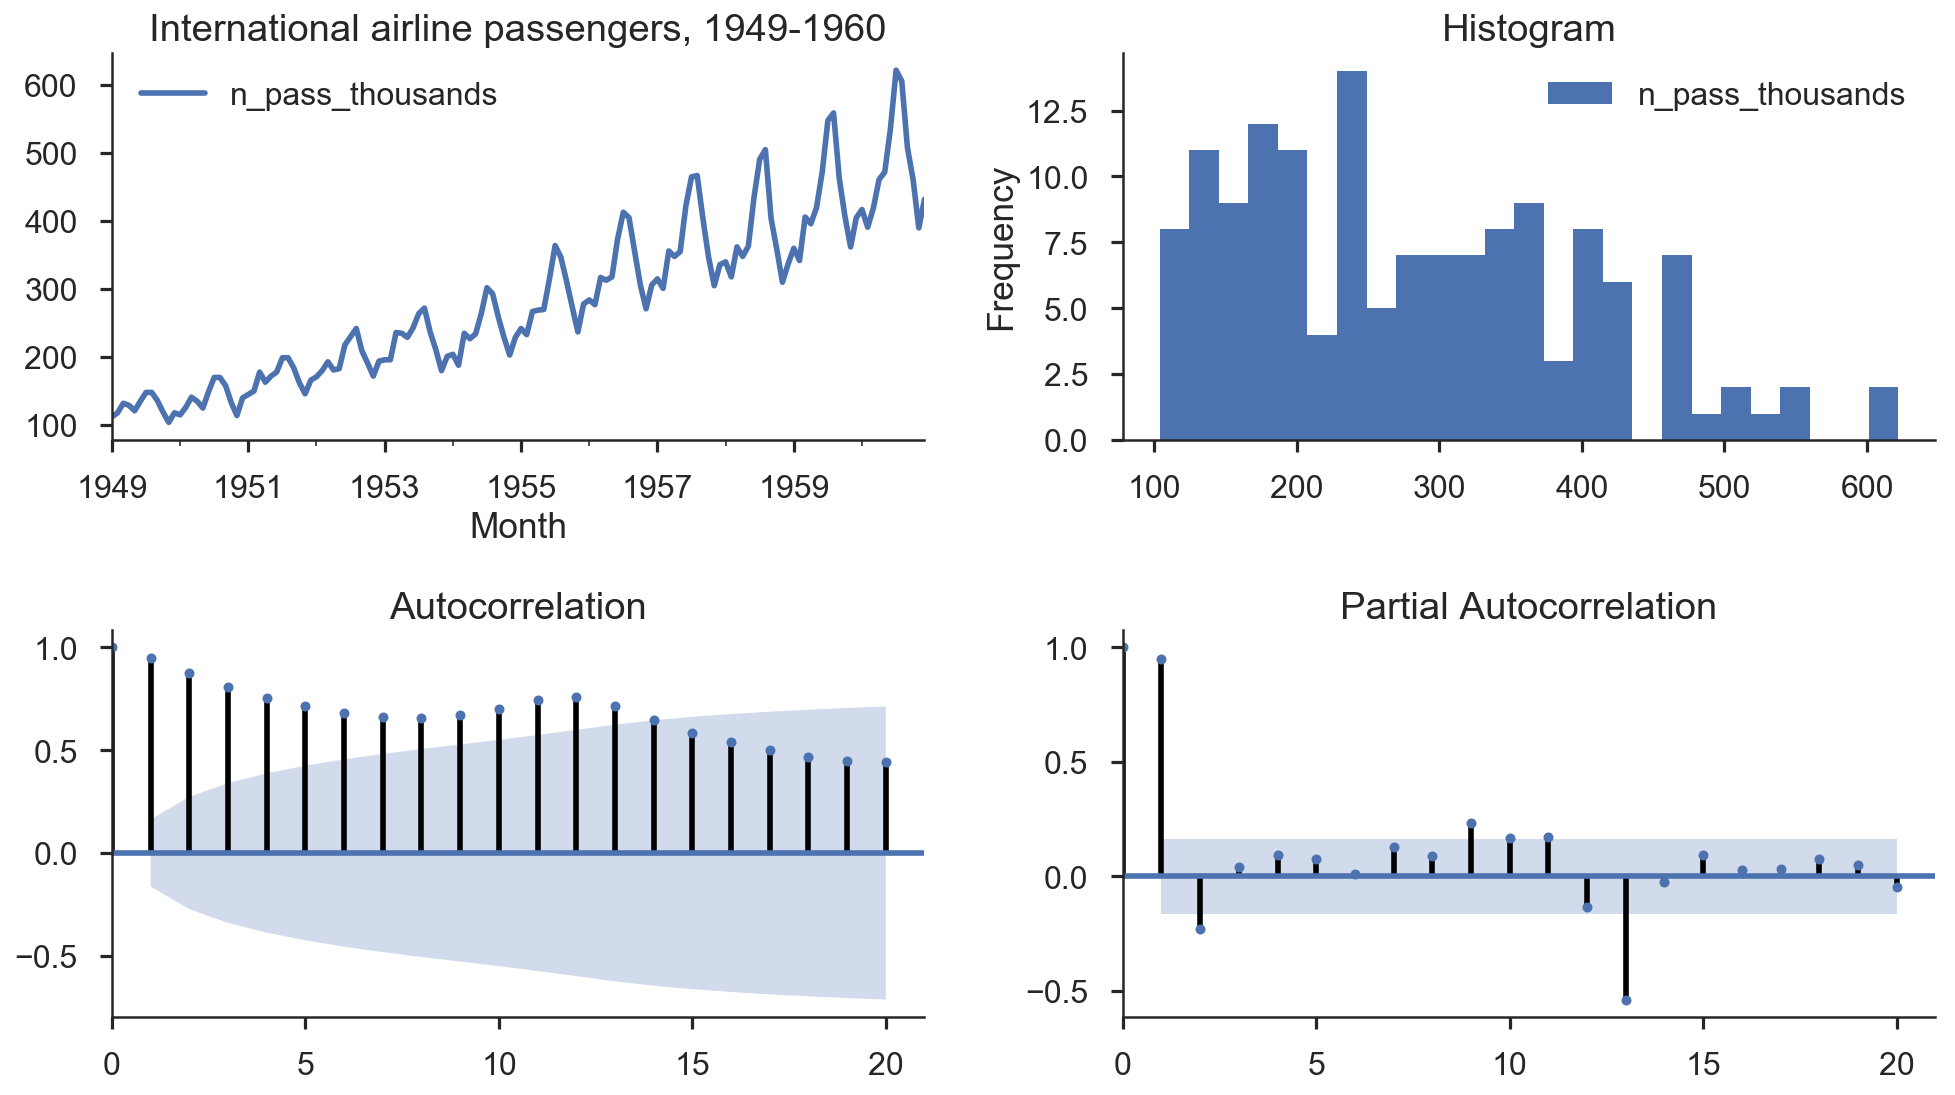

In [6]:
tsplot(air, title='International airline passengers, 1949-1960', lags=20);

### Observations of these graphs:

* The airline passengers displays an increasing trend (over time)
* There appears to be *seasonality*
* The autocorrelations do not just gradually decline

In [7]:
# Take log of the series
air['lnair'] = np.log(air)
print(air['lnair'].head(),"\n")
print(air['lnair'].shape,"\n")

# Take first difference of the series
#air_ln_diff = air['lnair'].diff() - air['lnair'].shift()
air_ln_diff = air['lnair'].diff()
air_ln_diff = air_ln_diff.dropna()
print(air_ln_diff.head(),"\n")
print(air_ln_diff.shape,"\n")

Month
1949-01-01   4.71850
1949-02-01   4.77068
1949-03-01   4.88280
1949-04-01   4.85981
1949-05-01   4.79579
Name: lnair, dtype: float64 

(144,) 

Month
1949-02-01    0.05219
1949-03-01    0.11212
1949-04-01   -0.02299
1949-05-01   -0.06402
1949-06-01    0.10948
Name: lnair, dtype: float64 

(143,) 



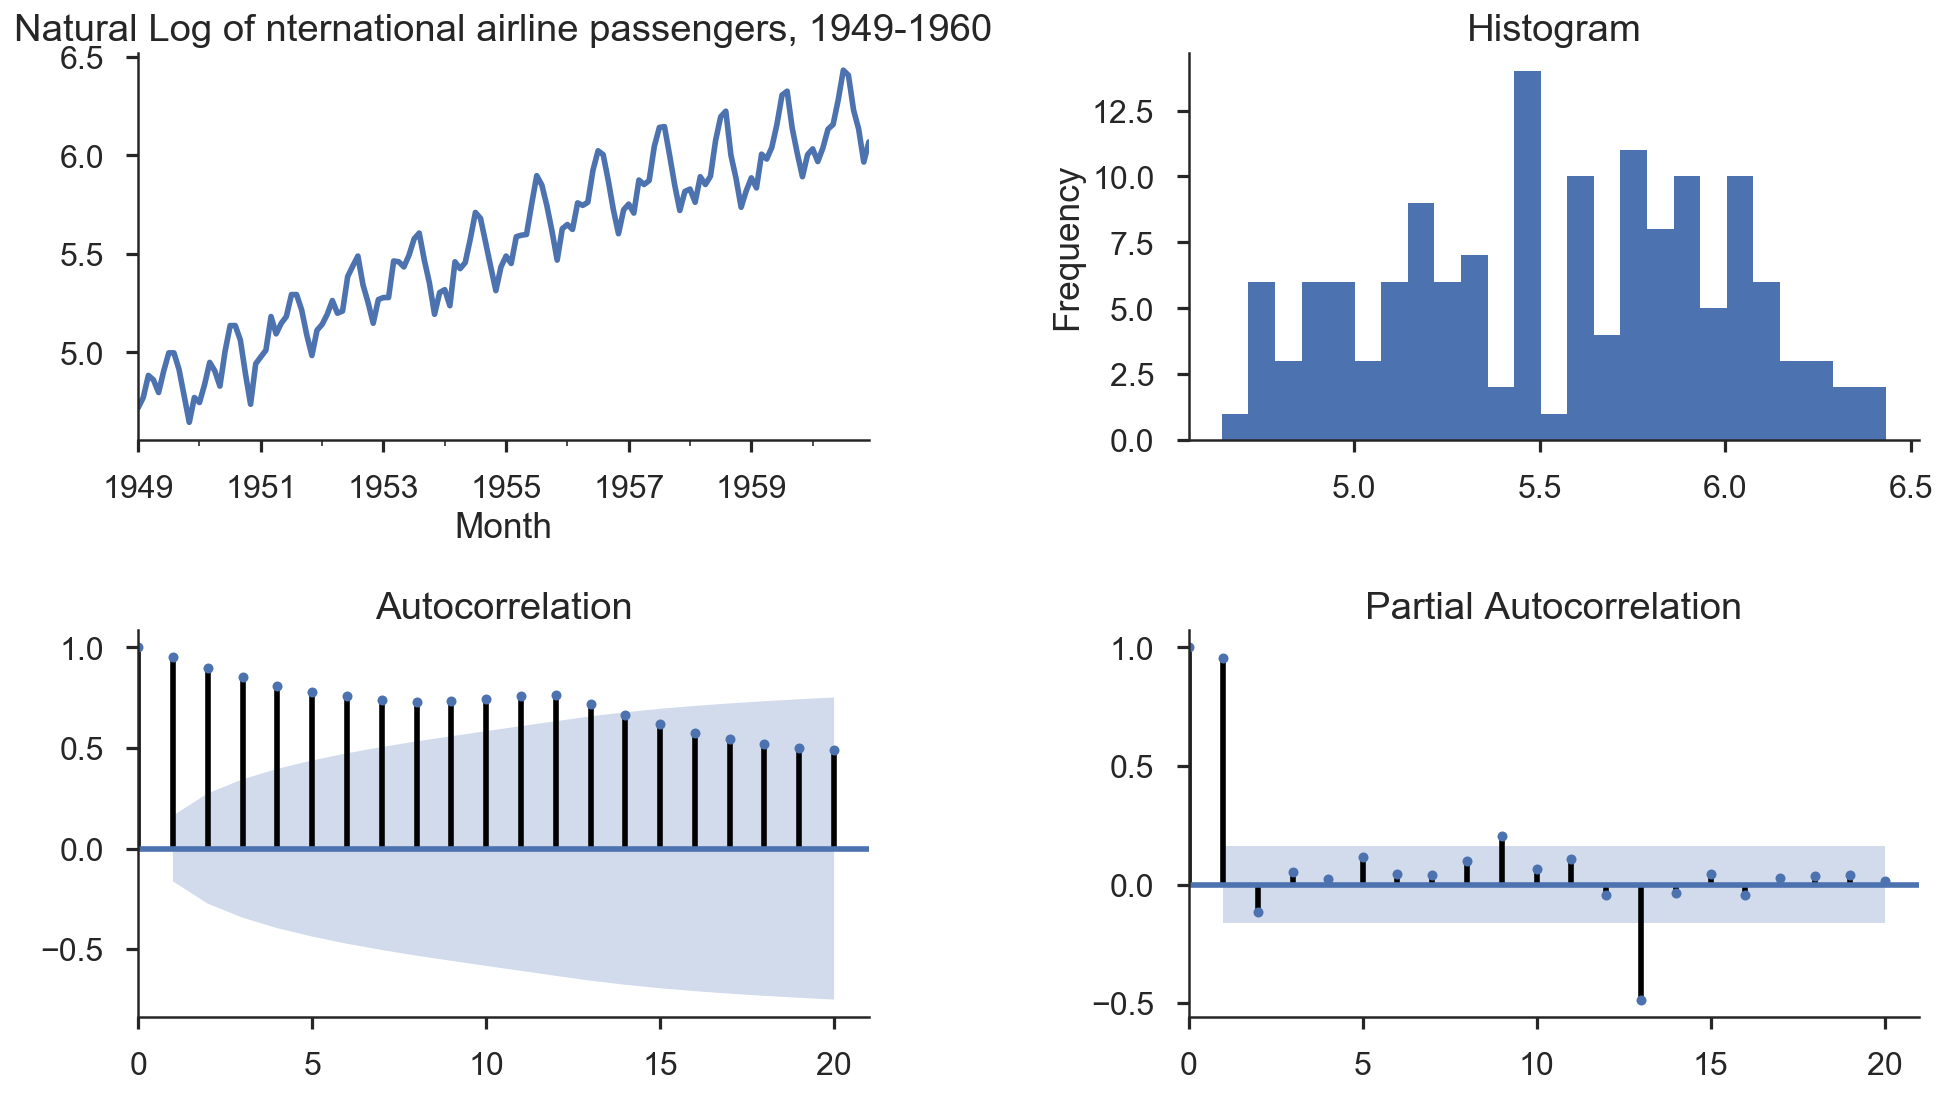

In [8]:
tsplot(air['lnair'], title='Natural Log of nternational airline passengers, 1949-1960', lags=20);

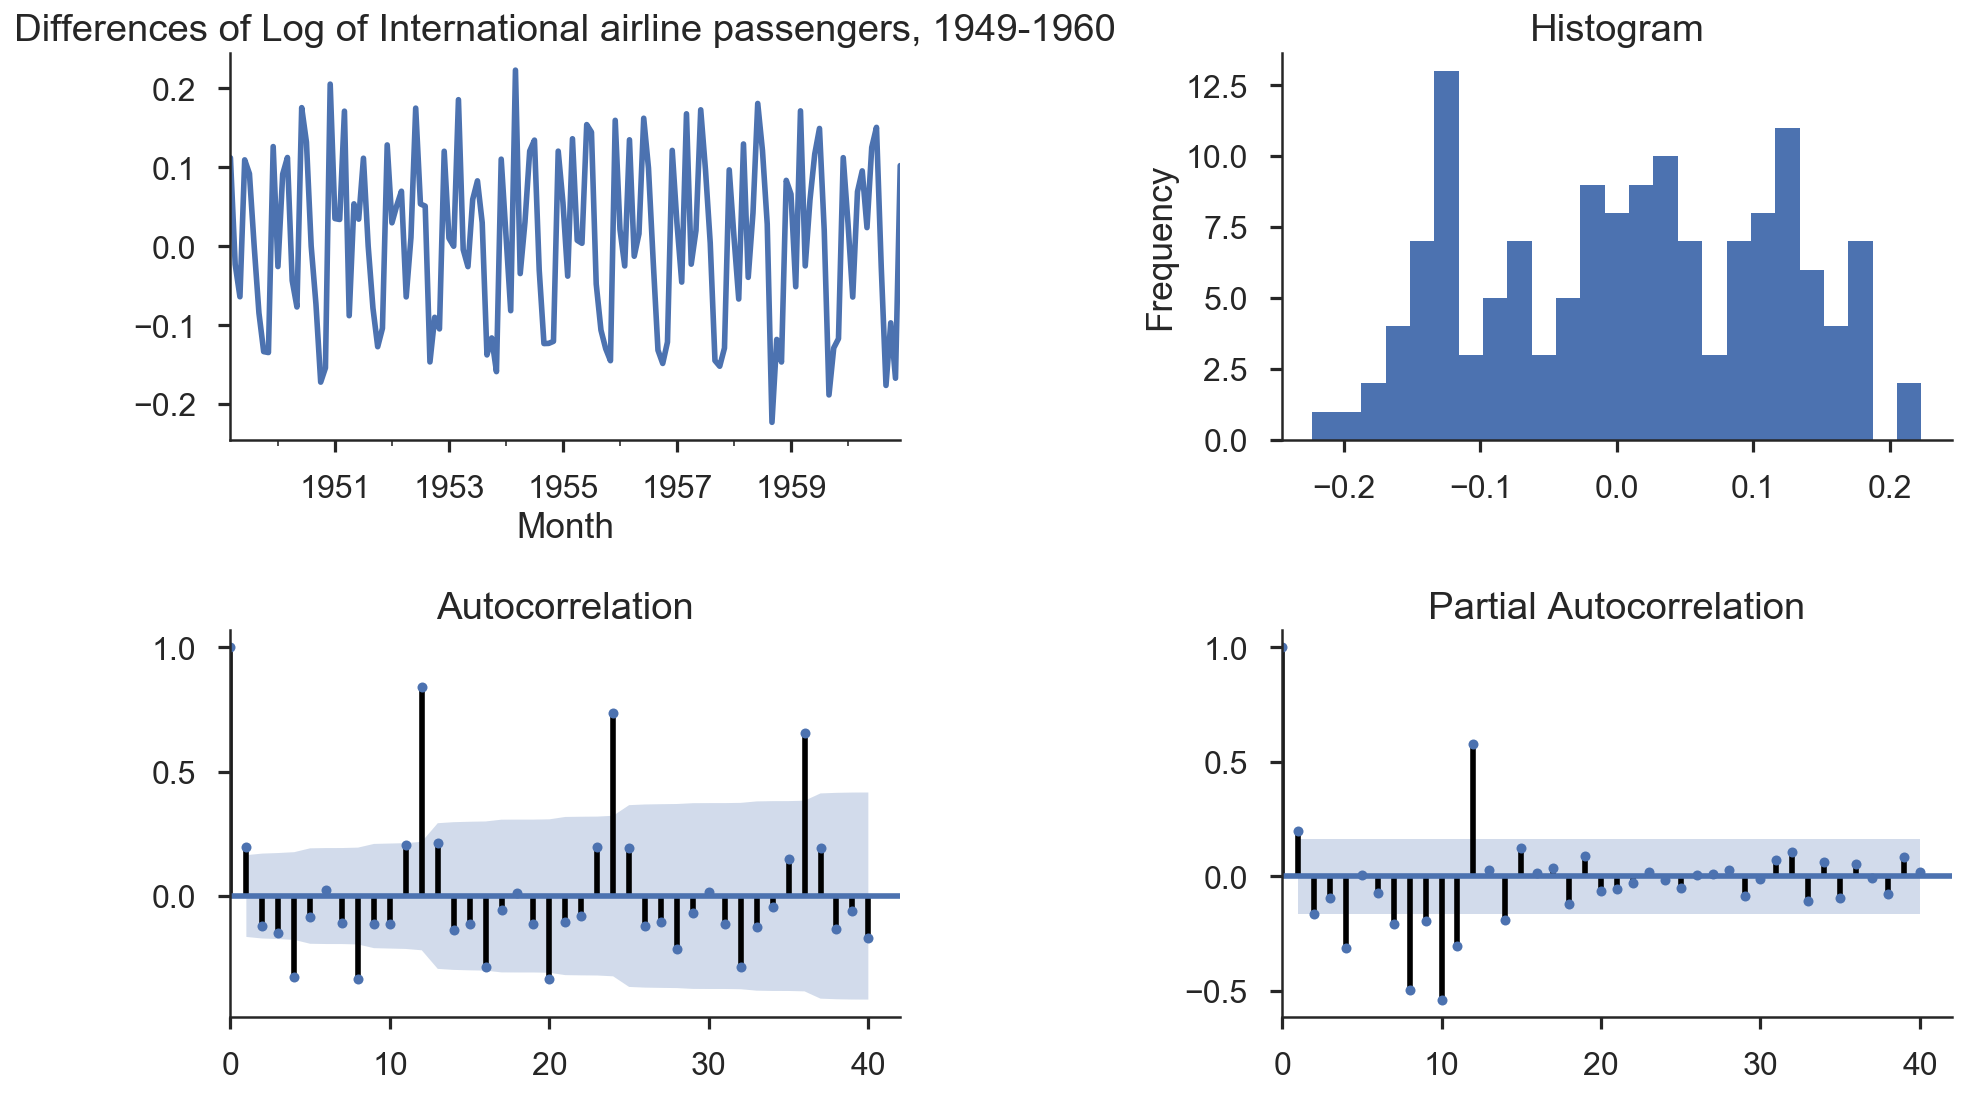

In [9]:
tsplot(air_ln_diff[1:], title='Differences of Log of International airline passengers, 1949-1960', lags=40);

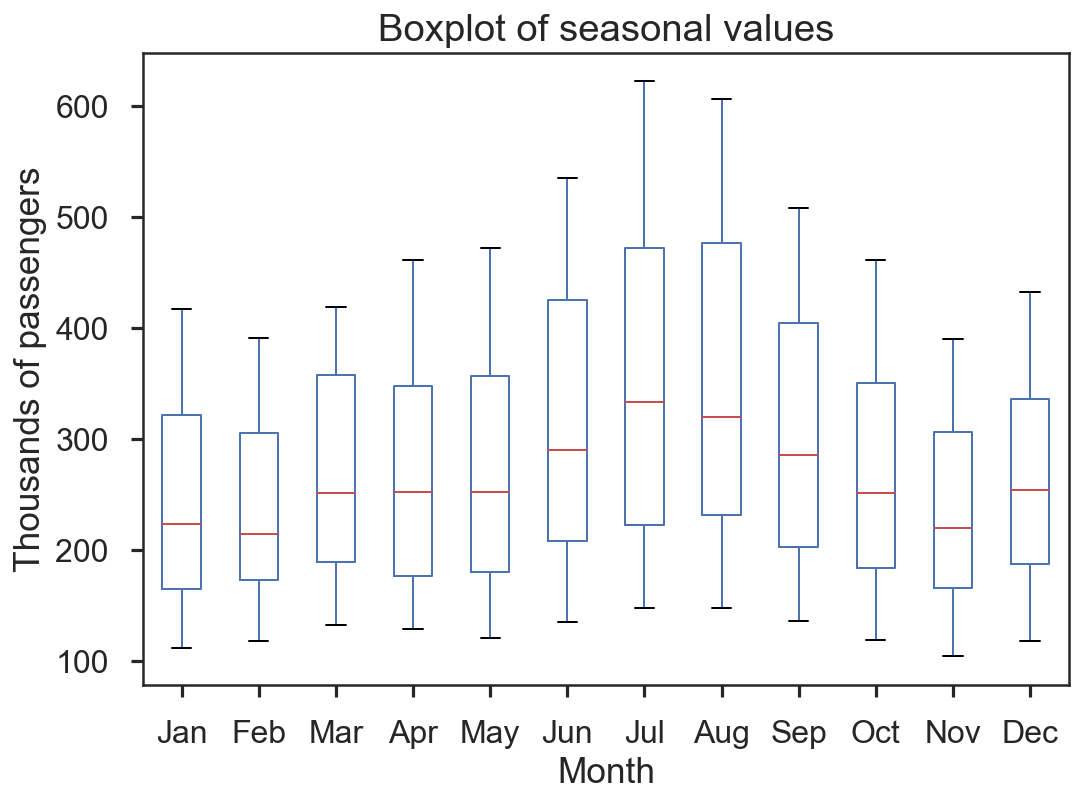

In [10]:
# An alternative way to detect seasonality

air['Month'] = air.index.strftime('%b')
air['Year'] = air.index.year

air_piv = air.pivot(index='Year', columns='Month', values='n_pass_thousands')

air = air.drop(['Month', 'Year'], axis=1)

# put the months in order
month_names = pd.date_range(start='2016-01-01', periods=12, freq='MS').strftime('%b')
air_piv = air_piv.reindex(columns=month_names)

# plot it
fig, ax = plt.subplots(figsize=(8, 6))
air_piv.plot(ax=ax, kind='box');

ax.set_xlabel('Month');
ax.set_ylabel('Thousands of passengers');
ax.set_title('Boxplot of seasonal values');
ax.xaxis.set_ticks_position('bottom')
fig.tight_layout();

### 4.1 Formulation of the Seasonal ARIMA Model

The *pure* seasonal autoregressive and moving average model, $ARMA(P,Q)$, take the from

$$\Phi_P(B^s)z_t=\Theta_Q(B^s)\epsilon_t$$ 

where 

$$\Phi_P(B^2)=1 - \Phi_1 B^s - \Phi_2 B^{2s} - \cdots - \Phi_P B^{Ps}$$

and 

$$\Theta_Q(B^2)=1 - \Theta_1 B^s - \Theta_2 B^{2s} - \cdots - \Theta_Q B^{Qs}$$

are the **seasonal autoregressive operator** and the **seasonal moving average operator** of orders $P$ and $Q$ with **seasonal period s**.

**Example:**

A first-order seasonal autoregressive moving average series over months (or $SARIMA(1,0,1,12)$) can be expressed as

$$ z_t = \Phi z_{t-12} + \epsilon_t + \Theta \epsilon_{t-12} $$

or

$$ (1 - \Phi B^{12})z_t = (1 + \Theta B^{12})\epsilon_t $$

In other words, this model capture the relationship between $z_t$ and its lags at the multiple of the yearly seasonal period $s=12$ months.  

The stationarity condition requires that $|\Phi|<1$ and the invertible condition requires that $|\Theta|<1$.

Similar to that for the ARIMA models, the table below summarize the behavior of the theoretical ACF and PACF of the pure seasonal ARMA models:

|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(P)**     |    tails off         | cutoff after lag $P$ |
| **MA(Q)**     | cutoff after lag $Q$ |    tails off         |
| **ARMA(P,Q)** |    tails off         |    tails off         |

* **Note that we use (p,d,q) to denote the orders for the non-seasonal components of the ARIMA models and (P,D,Q,s) to denote the orders for the seasonal components of the ARIMA model.**

The general formulation of the **Multiplicative Seasonal Autoregressive Integrated Moving Average (SARIMA)** model takes the following form:

$$ \phi_p(B) \Phi_P(B^s) \bigtriangledown^d \bigtriangledown^D_s z_t = \theta_q(B) \Theta_Q(B^s) \epsilon_t $$ 

where 

$\epsilon_t$ is a white noise process

$\phi_p(B)$ and $\theta_q(B)$ are non-seasonal autoregressive and moving average lag polynomials

$\Phi_P(B^s)$ and $\Theta_Q(B^s)$ are seasonal autoregressive and moving average lag polynomials

$\bigtriangledown^d \equiv (1-B)^d$ and $\bigtriangledown^D_s \equiv (1-B^s)^D$ are the difference (or integrated) components

Therefore, the general model is denoted as $\mathbf{ARIMA(p,d,q)\times(P,D,Q)_s}$



**Example:**

Unpacking the notation, the $\mathbf{ARIMA(0,1,1)\times(P,1,1)_12}$ model becomes

$$(1-B)(1-B^{12})z_t = (1+\theta B)(1+\Theta B^{12}) \epsilon_t$$

When multiplying the lag polynomials on both side, we get

$$ (1 - B - B^{12} + B^{13}) z_t = (1 + \theta B + \Theta B^{12} + \theta \Theta B^{13}) \epsilon_t $$

Simplify gives

$$ z_t = z_{t-1} + (z_{t-12} - z_{t-13}) + \epsilon_t + \theta \epsilon_{t-1} + \Theta \epsilon_{t-12} + \theta \Theta \epsilon_{t-13}$$


### 4.2 Building a Seasonal ARIMA Model for Forecasting

In [13]:
# Air Passengers Series
mod = sm.tsa.statespace.SARIMAX(air['lnair'], order=(2,1,0), seasonal_order=(2,1,0,12), simple_differencing=True)
sarima_fit1 = mod.fit()
print(sarima_fit1.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       D.DS12.lnair   No. Observations:                  131
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 12)   Log Likelihood                 242.980
Date:                            Tue, 08 May 2018   AIC                           -475.961
Time:                                    16:58:53   BIC                           -461.585
Sample:                                02-01-1950   HQIC                          -470.119
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3871      0.081     -4.808      0.000      -0.545      -0.229
ar.L2         -0.0885      0.099   

* Notice an additional argument *simple_differencing=True*. 

* This controls how the order of integration is handled in ARIMA models. 

* If *simple_differencing=True*, then the time series provided as endog is literally differenced and an ARMA model is fit to the resulting new time series. This implies that a number of initial periods are lost to the differencing process, however it may be necessary either to compare results to other packages (e.g. Stata's arima always uses simple differencing) or if the seasonal periodicity is large

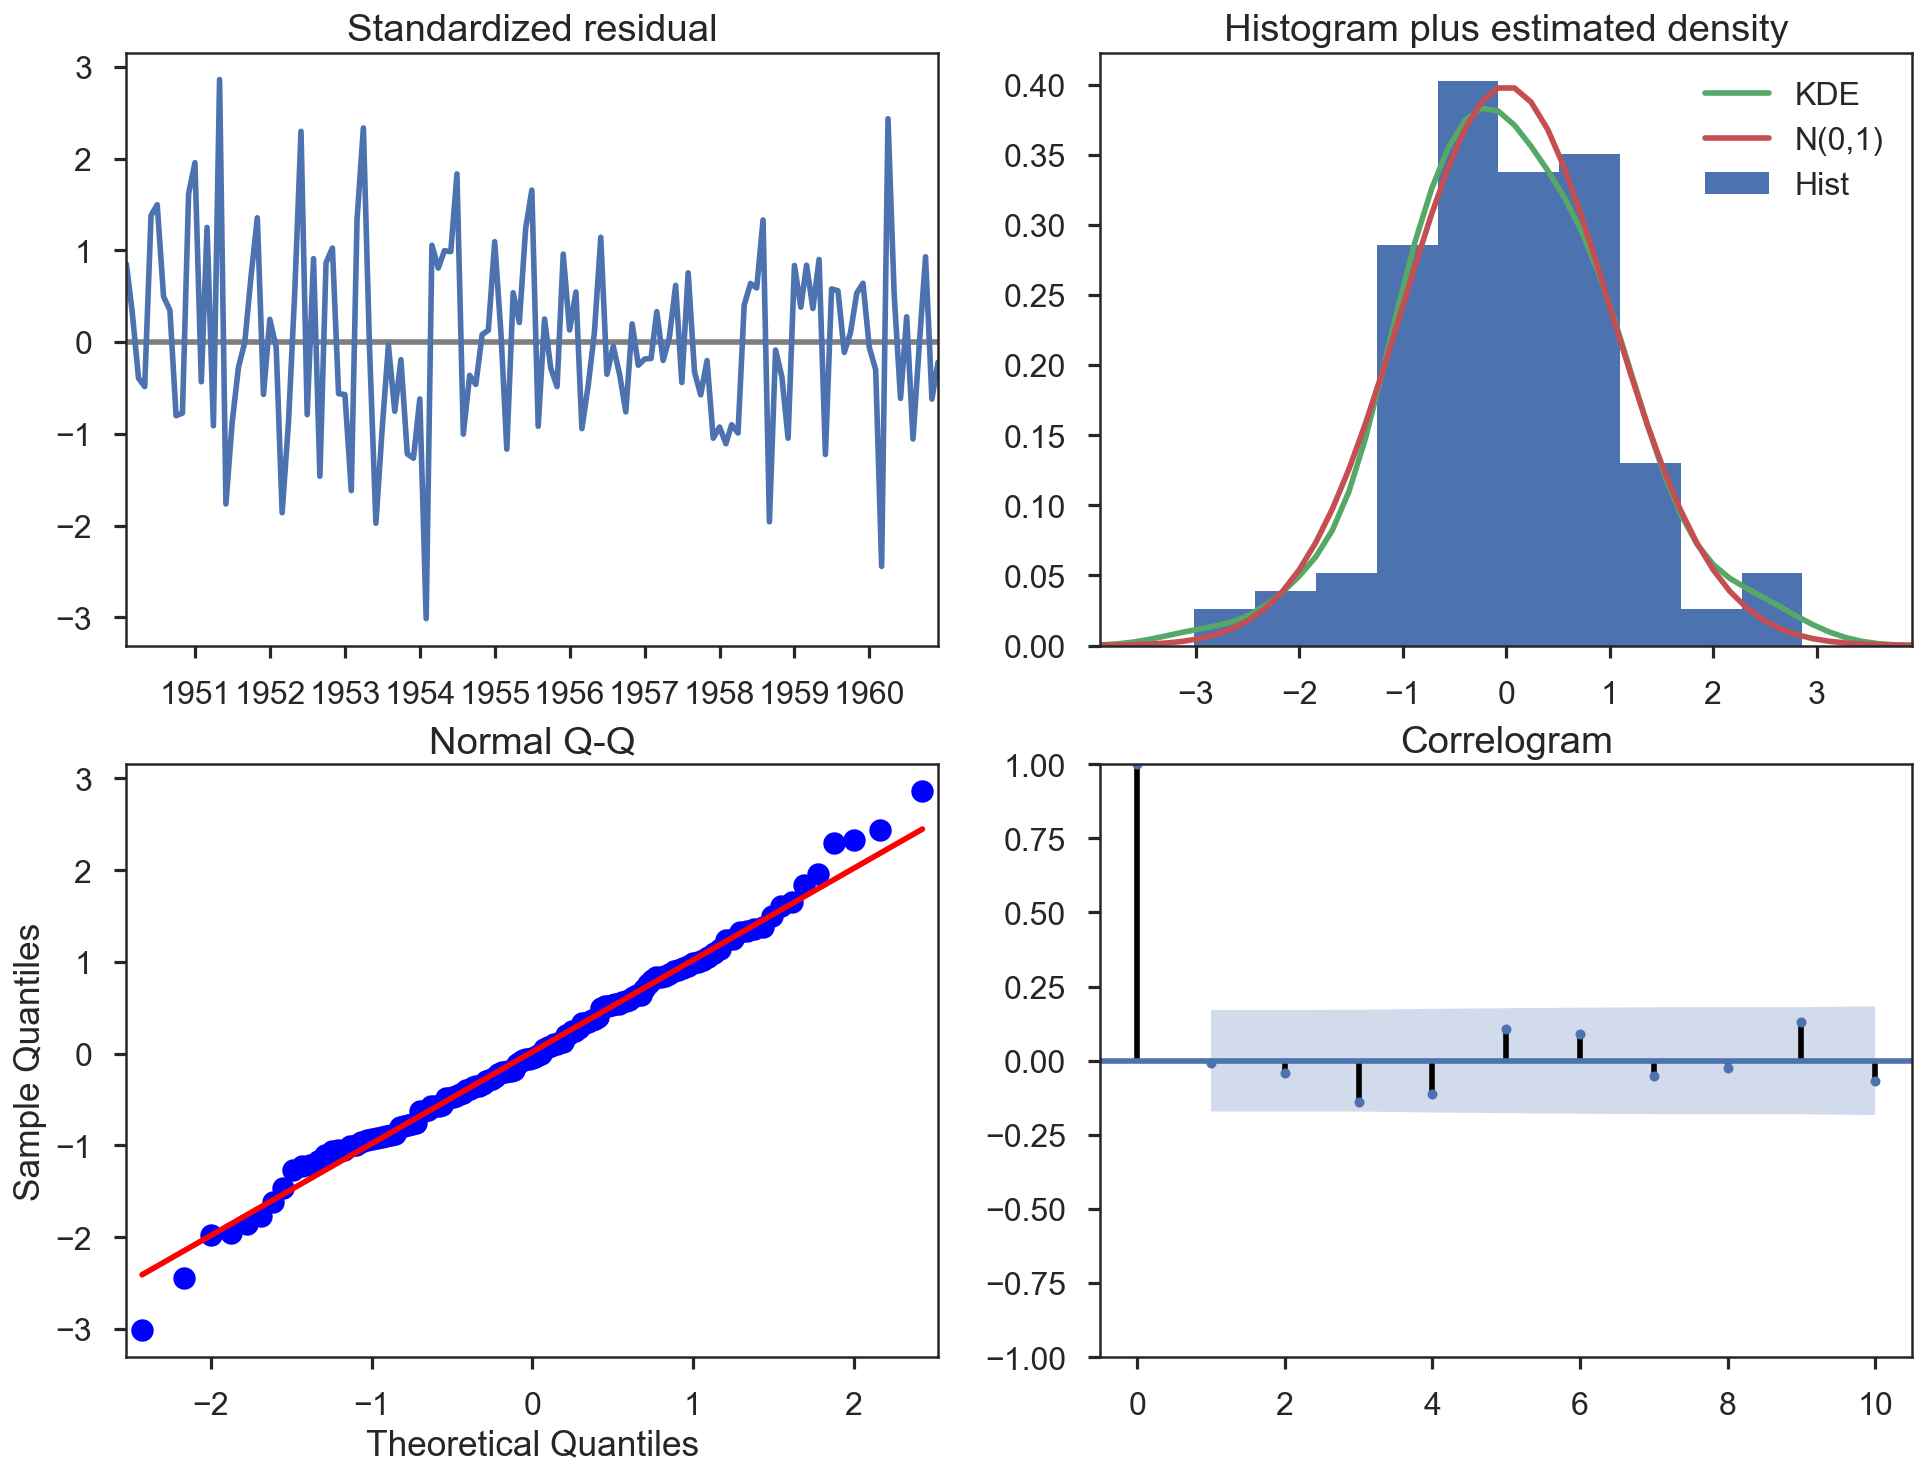

In [14]:
# Model Diagnostic

sarima_fit1.plot_diagnostics(figsize=(16, 12));

### Exercise 4: 

In [15]:
# Step 1: Import the data series
liquor = pd.read_csv('data/liquor.csv', header=0, index_col=0, parse_dates=[0])

# Step 1b: Create the training and testing series before analyzing the series
n_sample = liquor.shape[0]
n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train

liquor_train = liquor.iloc[:n_train]['Value']
liquor_test  = liquor.iloc[n_train:]['Value']
print(liquor_train.shape)
print(liquor_test.shape)
print("Training Series:", "\n", liquor_train.tail(), "\n")
print("Testing Series:", "\n", liquor_test.head())

(279,)
(14,)
Training Series: 
 Period
2014-11-01    4133
2014-12-01    5606
2015-01-01    3576
2015-02-01    3517
2015-03-01    3881
Name: Value, dtype: int64 

Testing Series: 
 Period
2015-04-01    3864
2015-05-01    4369
2015-06-01    4241
2015-07-01    4524
2015-08-01    4248
Name: Value, dtype: int64


In [16]:
# Step 2a: Examine the basic structure of the data
print("Data shape:", liquor_train.shape, "\n")
print("First 5 observations of the training data series:", "\n", liquor_train.head(), "\n")
print("Last 5 observations of the training data series:", "\n", liquor_train.tail())

Data shape: (279,) 

First 5 observations of the training data series: 
 Period
1992-01-01    1509
1992-02-01    1541
1992-03-01    1597
1992-04-01    1675
1992-05-01    1822
Name: Value, dtype: int64 

Last 5 observations of the training data series: 
 Period
2014-11-01    4133
2014-12-01    5606
2015-01-01    3576
2015-02-01    3517
2015-03-01    3881
Name: Value, dtype: int64


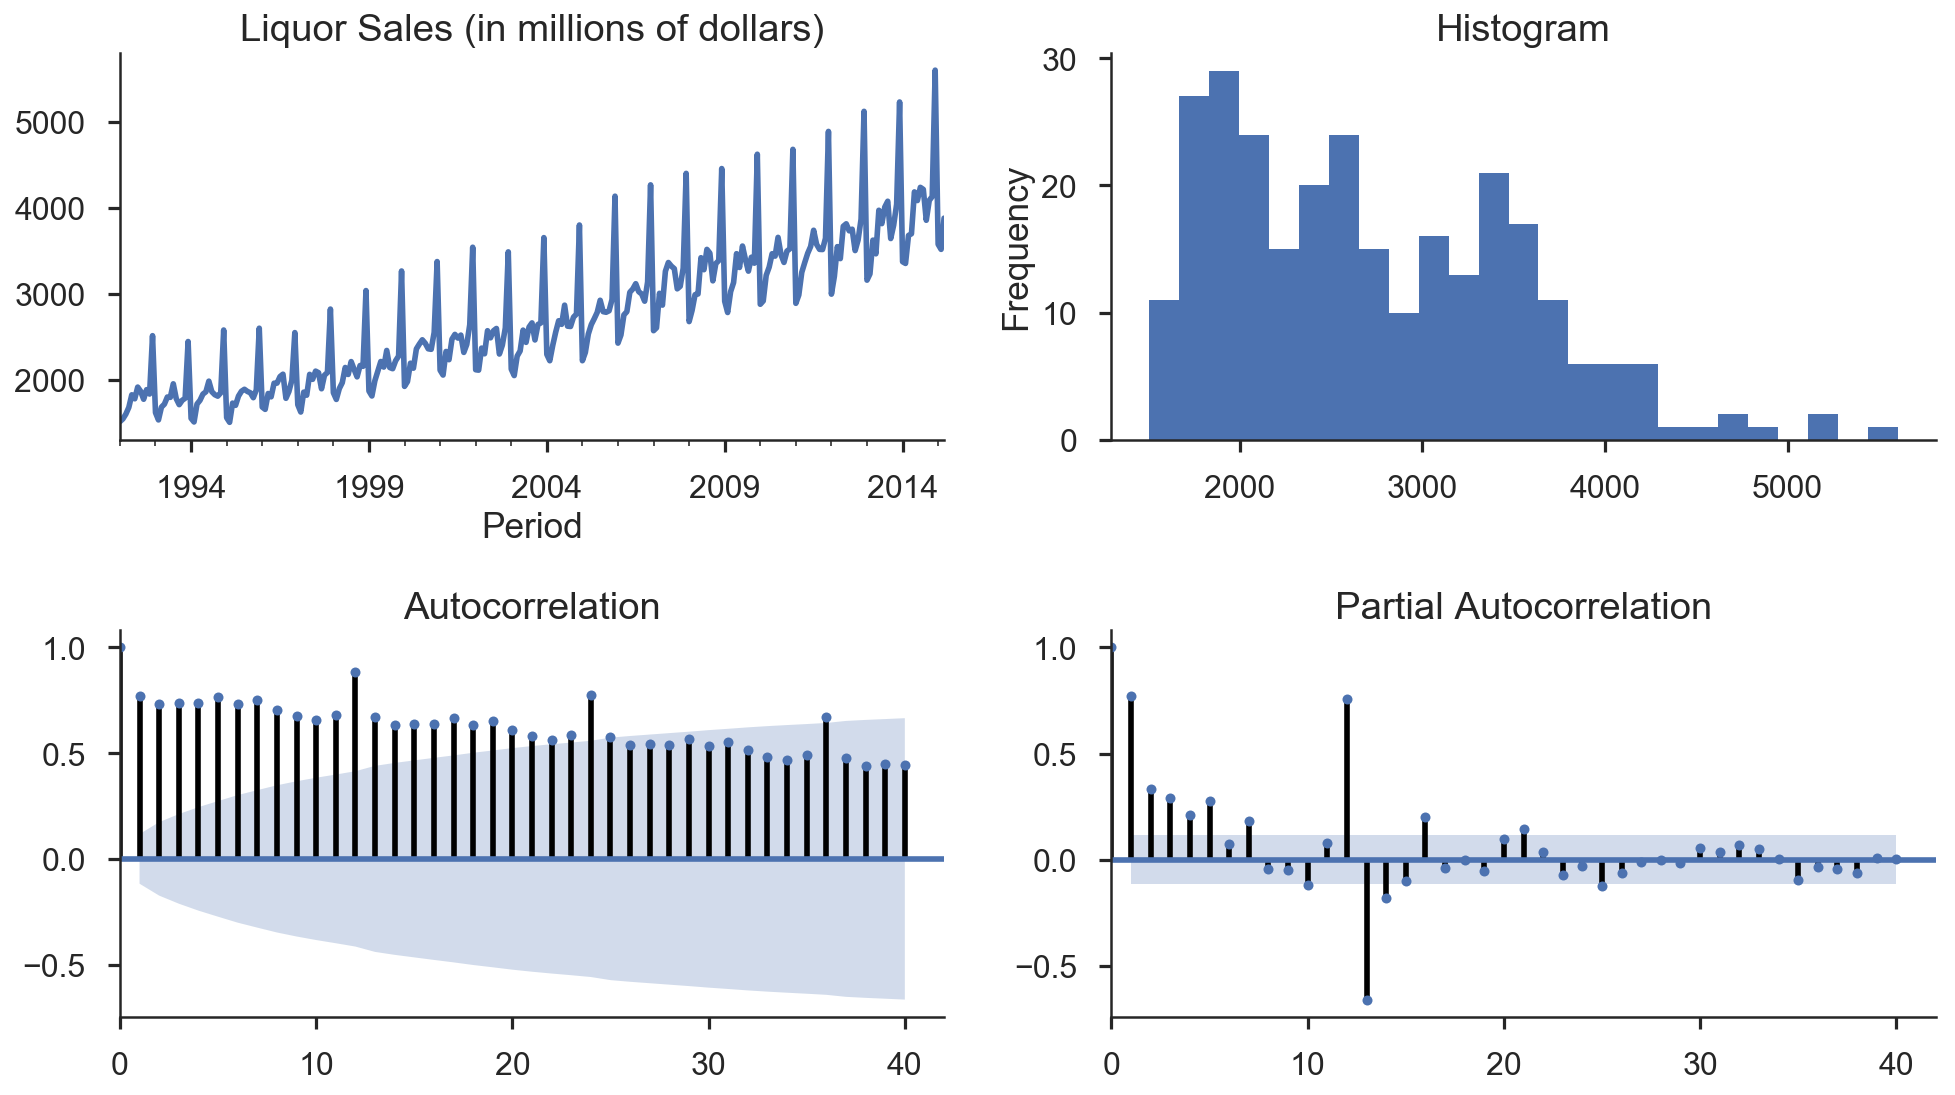

In [17]:
# Step 2b: Examine the series and use the visuals as clues for the choice of the orders of the ARIMA model
#tsplot(liquor_train, title='Liquor Sales (in millions of dollars), 2007-2016', lags=??);
tsplot(liquor_train, title='Liquor Sales (in millions of dollars)', lags=40);

In [ ]:
# Step 2c: Conduct any necessary transformations (such as natural log, difference, difference in natural log, etc )
# and repeat Step 2b


In [ ]:
# Step 3: Estimate an Seasonal ARIMA model
# Note: you will have to pick the orders (p,d,q)(P,D,Q)_s

#mod = sm.tsa.statespace.SARIMAX(liquor, order=(?,?,?), seasonal_order=(?,?,?,?))

mod = sm.tsa.statespace.SARIMAX(liquor_train, order=(0,1,1), seasonal_order=(0,1,0,12))
sarima_fit2 = mod.fit()
print(sarima_fit2.summary())

In [ ]:
# Step 4: Conduct model diagnostic check
sarima_fit2.plot_diagnostics();

# Discuss these plots

In [ ]:
# Step 5: Do a 14-step ahead forecast

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    
ax1.plot(liquor_train, label='In-sample data', linestyle='-')
# subtract 1 only to connect it to previous point in the graph
ax1.plot(liquor_test, label='Held-out data', linestyle='--')

# yes DatetimeIndex
pred_begin = liquor_train.index[sarima_fit2.loglikelihood_burn]
pred_end = liquor_test.index[-1]
pred = sarima_fit2.get_prediction(start=pred_begin.strftime('%Y-%m-%d'),
                                    end=pred_end.strftime('%Y-%m-%d'))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int(alpha=0.05)

ax1.plot(pred_mean, 'r', alpha=.6, label='Predicted values')
ax1.fill_between(pred_ci.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1], color='k', alpha=.2)
ax1.set_xlabel("Year")
ax1.set_ylabel("Liquor Sales (in millions of dollars)")
ax1.legend(loc='best');
fig.tight_layout();
## Discuss the results.  How does your forecast look?